In [1]:
import pandas as pd
import matplotlib
matplotlib.rcParams["font.family"] = "Arial"
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer

Matplotlib created a temporary cache directory at /scratch/naotok/13419516/matplotlib-mqv80n5y because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# PCA

## Load TPM matrix

In [ ]:
# Jul24
tpm_matrix_df = pd.read_csv("/rhome/naotok/bigdata/Ptbp1_astrocyte/Jul24/Shiba/results/expression/TPM.txt", sep = "\t")
tpm_matrix_df.head()

,gene_name,WT_F_1,WT_F_2,WT_F_3,KO_F_1,KO_M_3,KO_M_4
0,ENSMUSG00000000001,148.51,162.19,93.35,138.35,207.90,153.99
1,ENSMUSG00000000003,0.00,0.00,0.00,0.00,0.00,0.00
2,ENSMUSG00000000028,12.14,12.34,14.81,10.39,13.46,7.98
3,ENSMUSG00000000031,0.00,0.00,1.60,0.13,0.00,0.09
4,ENSMUSG00000000037,0.50,1.47,0.31,0.87,1.32,0.93


In [3]:
# mouse mESC neuronal differentiation (SRP055008)
tpm_matrix_PRJNA185305_df = pd.read_csv("/rhome/naotok/bigdata/NeuronalMaturationSplicing/splicing/PRJNA185305/Shiba/results/expression/TPM.txt", sep = "\t")
# group
group_df = pd.read_csv("/rhome/naotok/NeuronalMaturationSplicing/scripts/splicing/experiment_Shiba_PRJNA185305.tsv", sep = "\t", usecols = ["sample", "group"])
group_dict = {k: v for k, v in zip(group_df["sample"], group_df["group"])}
tpm_matrix_PRJNA185305_df.columns = [group_dict[x] + "_" + x if x != "gene_name" else x for x in tpm_matrix_PRJNA185305_df.columns]
tpm_matrix_PRJNA185305_df

,gene_name,DIV-8_SRR645824,DIV-8_SRR645826,DIV-8_SRR645828,DIV-8_SRR645830,DIV-4_SRR645833,DIV-4_SRR645835,DIV-4_SRR645837,DIV0_SRR645840,DIV0_SRR645842,...,DIV16_SRR645859,DIV16_SRR645861,DIV21_SRR645863,DIV21_SRR645865,DIV21_SRR645867,DIV21_SRR645870,DIV28_SRR645872,DIV28_SRR645875,DIV28_SRR645877,DIV28_SRR645879
0,ENSMUSG00000000001,213.51,209.40,218.88,229.01,261.05,260.61,269.88,343.55,332.39,...,88.48,81.80,58.90,63.05,62.02,60.86,37.75,39.22,39.58,41.38
1,ENSMUSG00000000003,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,ENSMUSG00000000028,101.14,98.10,99.55,71.84,77.60,80.62,80.78,52.79,56.77,...,1.68,1.65,2.28,1.59,1.76,1.47,2.03,1.40,1.00,1.25
3,ENSMUSG00000000031,0.29,0.46,0.62,79.90,2.28,1.94,2.22,13.61,11.76,...,121.21,124.49,62.03,73.41,80.12,48.57,130.77,120.99,57.94,115.85
4,ENSMUSG00000000037,3.66,3.16,2.94,2.62,2.86,2.74,3.10,7.24,6.00,...,0.77,0.71,0.30,0.39,0.23,0.36,0.41,0.24,0.33,0.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55482,ENSMUSG00000118655,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.20,0.00,0.18,0.18,0.00,0.00,0.00,0.00
55483,ENSMUSG00000118656,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
55484,ENSMUSG00000118657,2.04,0.00,0.00,0.00,0.00,3.51,2.31,0.00,1.28,...,0.00,1.54,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.66
55485,ENSMUSG00000118658,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


## Merge

In [ ]:
tpm_matrix_merge_df = pd.merge(tpm_matrix_df, tpm_matrix_PRJNA185305_df, on = "gene_name")
tpm_matrix_merge_df = tpm_matrix_merge_df.set_index("gene_name")

In [5]:
def mtx2pca(df, genes) -> pd.DataFrame:
    '''
    Perform PCA on the input dataframe

    Args:
    - df (pd.DataFrame): input dataframe
    - genes (int): number of highly-variable genes to calculate PCs

    Returns:
    - feature_df (pd.DataFrame): dataframe containing principal components
    - contribution_df (pd.DataFrame): dataframe containing the contribution of each principal component
    '''
    df = df.dropna()
    # Keep rows of top n highly-variable genes
    if df.shape[0] > genes:
        df = df.loc[df.var(axis=1).sort_values(ascending=False).index[:genes]]
    # Z-score normalization across samples
    normalized_df = df.T.apply(stats.zscore, ddof = 1)
    # PCA
    pca = PCA()
    pca.fit(normalized_df)
    # Feature
    feature = pca.transform(normalized_df)
    feature_df = pd.DataFrame(feature, columns=["PC{}".format(x + 1) for x in range(len(feature))])
    feature_df.index = df.columns
    # Contribution
    contribution_df = pd.DataFrame(pca.explained_variance_ratio_, index=["PC{}".format(x + 1) for x in range(len(feature))])
    return(feature_df, contribution_df)

In [6]:
feature_df, contribution_df = mtx2pca(tpm_matrix_merge_df, 3000)
PC1_contribution = (contribution_df[0][0]*100).round(2)
PC2_contribution = (contribution_df[0][1]*100).round(2)
pca_df = feature_df.copy()
pca_df["group"] = pca_df.index.map(lambda x: x.split("_")[0])
pca_df["group"] = pca_df["group"].map(lambda x: x if x != "KO" else "Ptbp1 cKO").map(lambda x: "Control" if x == "WT" else x)

## Plot

In [7]:
color_palette_dict = {}
viridis = sns.color_palette("viridis", n_colors = 8).as_hex()
Set2 = sns.color_palette("Set2").as_hex()
i = 0
for group in ["DIV-8", "DIV-4", "DIV0", "DIV1", "DIV7", "DIV16", "DIV21", "DIV28"]:
    color_palette_dict[group] = viridis[i]
    i+=1
color_palette_dict["Control"] = "black"
color_palette_dict["Ptbp1 cKO"] = "red"
color_palette_dict

{'DIV-8': '#482878',
 'DIV-4': '#3e4989',
 'DIV0': '#31688e',
 'DIV1': '#26828e',
 'DIV7': '#1f9e89',
 'DIV16': '#35b779',
 'DIV21': '#6ece58',
 'DIV28': '#b5de2b',
 'Control': 'black',
 'Ptbp1 cKO': 'red'}

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


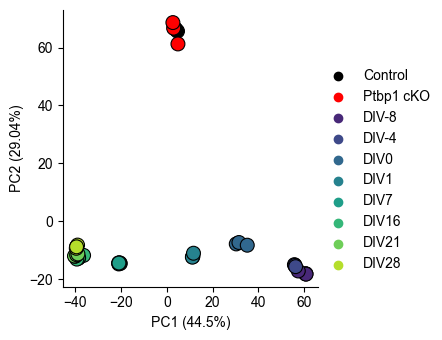

In [ ]:
g = sns.relplot(
    data = pca_df,
    x = "PC1",
    y = "PC2",
    hue = "group",
    hue_order = ["Control", "Ptbp1 cKO"] + ["DIV-8", "DIV-4", "DIV0", "DIV1", "DIV7", "DIV16", "DIV21", "DIV28"],
    s = 100,
    edgecolor = "black",
    height = 3.5,
    aspect = 1,
    palette = color_palette_dict
)
g.set_xlabels(f"PC1 ({PC1_contribution}%)")
g.set_ylabels(f"PC2 ({PC2_contribution}%)")
g._legend.set_title("")
plt.savefig("/rhome/naotok/bigdata/Ptbp1_astrocyte/Jul24/figure/PCA_TPM_vs_neuron_PRJNA185305.png", bbox_inches = "tight", dpi = 1000)

# Correlation of TPM

In [ ]:
DEG_path_dict = {
    "astrocyte": "/rhome/naotok/bigdata/Ptbp1_astrocyte/Jul24/Shiba/results/expression/DEG.txt",
    "neuron": "/rhome/naotok/bigdata/NeuronalMaturationSplicing/splicing/PRJNA185305/Shiba_DIV0vsDIV28/results/expression/DEG.txt"
}

In [10]:
info_df = pd.read_csv("/rhome/naotok/bigdata/genome_annotation/Mouse/Mus_musculus.GRCm38.102.exon.info.tsv", sep = "\t", usecols = ["gene_id", "gene_name", "chr"])
info_df = info_df.drop_duplicates()

In [11]:
DEG_set = set()
for path in DEG_path_dict:    
    DEG_df = pd.read_csv(DEG_path_dict[path], sep = "\t")
    DEG_df = DEG_df.rename(columns = {"gene_name": "gene_id"})
    DEG_df = pd.merge(DEG_df, info_df, on = "gene_id", how = "left")
    DEG_df = DEG_df[~((DEG_df["chr"] == "chrX") | (DEG_df["chr"] == "chrY"))]
    DEG_tmp = set(DEG_df[(DEG_df["padj"] < 0.05) & (DEG_df["log2FoldChange"].abs() > 1)]["gene_id"])
    DEG_set = DEG_set | DEG_tmp if len(DEG_set) != 0 else DEG_tmp

In [12]:
len(DEG_set)

11737

In [13]:
tpm_matrix_merge_melt_df = tpm_matrix_merge_df.reset_index().melt(id_vars = "gene_name", var_name = "sample", value_name = "TPM")
tpm_matrix_merge_melt_df = tpm_matrix_merge_melt_df[tpm_matrix_merge_melt_df["gene_name"].isin(DEG_set)]
tpm_matrix_merge_melt_df["group"] = tpm_matrix_merge_melt_df["sample"].map(lambda x: x.split("_")[0])
tpm_matrix_merge_melt_df = tpm_matrix_merge_melt_df.groupby(["gene_name", "group"], as_index = False).mean()
tpm_matrix_mean_df = tpm_matrix_merge_melt_df.pivot(index = "gene_name", columns = "group", values = "TPM")
tpm_matrix_mean_df = tpm_matrix_mean_df.rename(columns = {"WT": "Control", "KO": "Ptbp1 cKO"})
tpm_matrix_mean_df = tpm_matrix_mean_df[["Control", "Ptbp1 cKO", "DIV0", "DIV28"]]
tpm_matrix_mean_df = tpm_matrix_mean_df[tpm_matrix_mean_df.apply(lambda x: x > 10, axis = 1).any(axis = 1)]
tpm_matrix_mean_df = np.log2(tpm_matrix_mean_df+1)
tpm_matrix_mean_df

/scratch/naotok/13419516/ipykernel_2417830/1535651331.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tpm_matrix_merge_melt_df = tpm_matrix_merge_melt_df.groupby(["gene_name", "group"], as_index = False).mean()


group,Control,Ptbp1 cKO,DIV0,DIV28
gene_name,,,,
ENSMUSG00000000001,7.084100,7.390140,8.461643,5.339226
ENSMUSG00000000028,3.817282,3.537296,5.859473,1.275007
ENSMUSG00000000031,0.616671,0.102098,4.157313,6.746682
ENSMUSG00000000056,4.848665,4.959461,5.747298,6.521483
ENSMUSG00000000078,5.012569,5.670161,7.243110,5.264724
...,...,...,...,...
ENSMUSG00000118346,6.864434,6.763146,7.259712,4.630959
ENSMUSG00000118383,4.146764,4.468801,3.197970,0.163499
ENSMUSG00000118502,2.490570,2.841973,3.106013,4.716305


In [14]:
tpm_matrix_mean_df.corr(method = "spearman")

group,Control,Ptbp1 cKO,DIV0,DIV28
group,,,,
Control,1.000000,0.986590,0.429793,0.364976
Ptbp1 cKO,0.986590,1.000000,0.427622,0.365542
DIV0,0.429793,0.427622,1.000000,0.257850
DIV28,0.364976,0.365542,0.257850,1.000000


/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


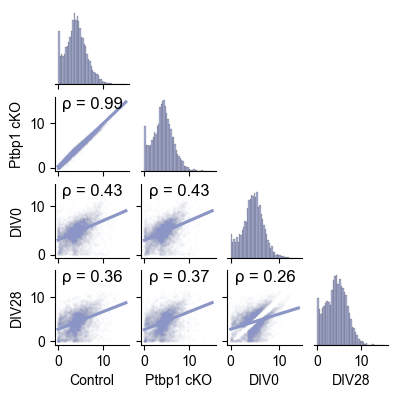

In [ ]:
g = sns.pairplot(
    data = tpm_matrix_mean_df,
    kind = "reg",
    corner = True,
    plot_kws = {
        "scatter_kws": {"alpha": 0.1, "s": 0.05, "color": "#8c96c6"},
        "line_kws": {"color": "#8c96c6"}
    },
    diag_kws = {"color": "#8c96c6"},
    height = 1
)
# Calculate and add Spearman's correlation coefficients in the same plot space
for i in range(len(g.axes)):
    for j in range(i):
        ax = g.axes[i, j]
        x = tpm_matrix_mean_df.iloc[:, j]
        y = tpm_matrix_mean_df.iloc[:, i]
        corr, _ = stats.spearmanr(x, y)
        ax.annotate(f"ρ = {corr:.2f}", 
                    xy=(0.1, 0.9), xycoords='axes fraction', 
                    ha='left', va='center', fontsize=12)
plt.savefig("/rhome/naotok/bigdata/Ptbp1_astrocyte/Jul24/figure/pairplot_TPM_vs_neuron_PRJNA185305.png", bbox_inches = "tight", dpi = 800)